# Finding Metabolic Depth in Murine Liver Metabolomics data

In [1]:
import sys
import os
import random
import math
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

import multi_gaston
from multi_gaston import data_processing, multi_gaston, process_NN_output

## Step 1: Pre-processing

The data input for MET-MAP(Multi-GASTON) should contain: 
- N x 2 spatial coordinate matrix,
- N x 1 total ion count,
- N x M metabolite abundance matrix
- list of metabolite names

where N=number of spatial locations and M=number of metabolites.

For murine liver data pre-processing, we will first perform TIC normalization and log-transform, and then divide the data into non-overlapping rectangular crops to feed into the neural network.

In [2]:
!mkdir -p livm160_1

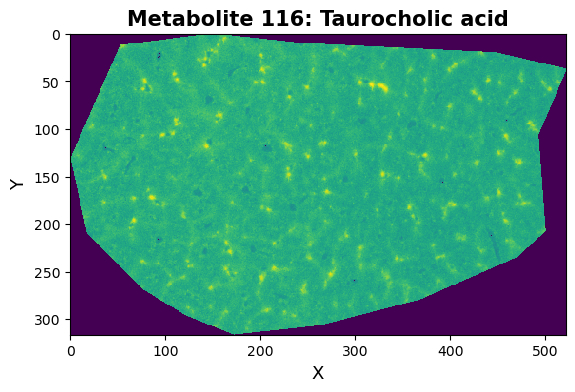

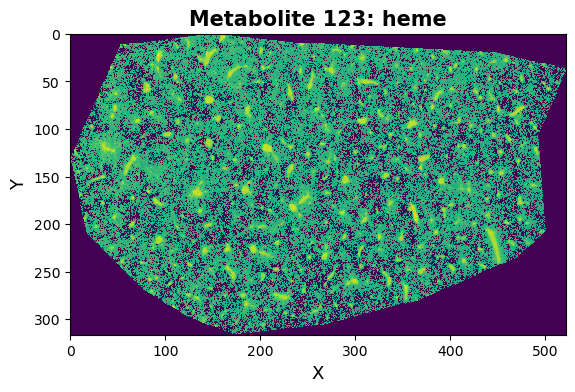

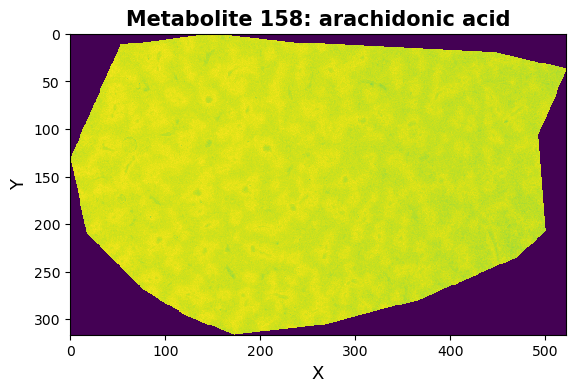

In [3]:
# load the metabolite names
names = pd.read_excel('livm_meta.xlsx',header=1).to_numpy()

# data: first 2 columns are 2D coordinates, 3rd column TIC, remaining columns are raw abundance
data_dir = '240526_livM160_1_ROI_02.csv'
save_dir = 'livm160_1'
X,Y,S,A = data_processing.process(data_dir)
data = np.hstack((S,A))

# plot the some marker metabolites abundance to visualize the tissue
pv_id = np.where(names[:,0]=='Taurocholic acid')[0][0]
heme_id = np.where(names[:,0]=='heme')[0][0]
cv_id = np.where(names[:,0]=='arachidonic acid')[0][0]
data_processing.plot_mat(data,pv_id,names[:,0])
data_processing.plot_mat(data,heme_id,names[:,0])
data_processing.plot_mat(data,cv_id,names[:,0])

Next, we crop the data into rectangles. The code below creates a grid of crops panning over the tissue region, but depending on individual tissue shape and quality, users should adjust the positions and size of the crops to best cover the tissue region and avoid local abnormalities such as tissue tears.

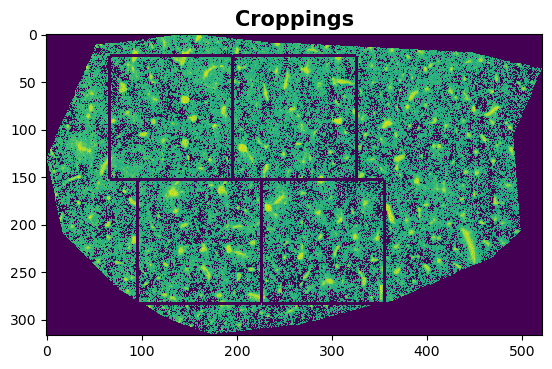

In [4]:
# basic grid setup
cropx_size = 130
cropy_size = 130
crop_n_x = X // cropx_size 
crop_n_y = Y // cropy_size - 1
crop_n = crop_n_x*crop_n_y
# adjust where the grid starts horizontally and vertically
offset_x = int((X-cropx_size*crop_n_x)/2) - 5
offset_y = int((Y-cropy_size*crop_n_y)/2) 
cropxs = [(offset_x + i*cropx_size,offset_x + (i+1)*cropx_size) for i in range(crop_n_x)]
cropys = [(offset_y + i*cropy_size,offset_y + (i+1)*cropy_size) for i in range(crop_n_y)]
crop_coor = list(product(cropxs,cropys))
# adjust a subset of crops, here we are moving the 2nd row of crops to the right by 30 spots
crop_coor = [((x1,x2),(y1+30,y2+30)) if x1>100 else ((x1,x2),(y1,y2)) for ((x1,x2),(y1,y2)) in crop_coor]
crop = np.zeros(S.shape[0])

# visualize the crops
vein_mat = np.zeros((X,Y))
for i in range(0,S.shape[0]):
    row = S[i,:]
    x = int(row[0])
    y = int(row[1])
    vein_mat[x,y] = data[i,3+heme_id]
    for k in range(crop_n):
        # select the final set of crops
        if k not in [0,1,3,4]: continue
            
        (x1,x2),(y1,y2) = crop_coor[k]
        if x > x1 and x < x2 and y > y1 and y < y2:
            crop[i] = k+1
        if (((y >= y1-1 and y <= y1+1) or (y >= y2-1 and y <= y2+1)) and x > x1 and x < x2
            ) or (((x >= x1-1 and x <= x1+1) or (x >= x2-1 and x <= x2+1)) and y > y1 and y < y2):
            vein_mat[x,y] = 0

plt.imshow(vein_mat, interpolation='nearest')
plt.title("Croppings",fontsize=15,fontweight='demi')
plt.savefig(save_dir+f'/croppings.pdf')
plt.show()
plt.close()

# save the selected crops
for k in [0,1,3,4]:
    np.savetxt(save_dir + f'/livm160_1_crop_{k+1}.csv',data[crop == k+1], delimiter=",")

## Step 2: Train MET-MAT neural network

We include how to train the neural network with two options: (1) a command line script and (2) in a notebook. We typically train the neural network 10 different times, each with a different seed. 

### Option 1: train in notebook

We first transform the input matrices into torch tensors and z-score normalize.

In [5]:
# N x M feature matrix A and N x 2 coordinate matrix S are outputs from Step 1
crop = pd.read_csv(save_dir+'/livm160_1_crop_1.csv',header=None).to_numpy()
S,A=crop[:,:2],crop[:,3:]
S_torch, A_torch = data_processing.tensor_transform_inputs(S,A)

Next we train the neural network, once for each random initialization. 

In [6]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, e.g. [20,20] means two hidden layers of size 20 hidden neurons
met_dep_arch=[350] # architecture for metabolic depth neural network d(x,y) : R^2 -> R 
abundance_arch=[10,10] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 12000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir = save_dir # folder to save model runs
optimizer = "adam"
num_restarts = 10

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}/"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list, lasso_loss = multi_gaston.train(S_torch, A_torch,
                          S_hidden_list=met_dep_arch, A_hidden_list=abundance_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          SAVE_PATH=out_dir_seed, optim=optimizer, seed=seed)

training neural network for seed 0
training neural network for seed 1
training neural network for seed 2
training neural network for seed 3
training neural network for seed 4
training neural network for seed 5
training neural network for seed 6
training neural network for seed 7
training neural network for seed 8
training neural network for seed 9


## Step 3: Process neural network output

If you use the model trained above, then figures will closely match the manuscript --- but not exactly match --- due to PyTorch non-determinism in seeding (see https://github.com/pytorch/pytorch/issues/7068 ). 

We also include the model used in the paper for reproducibility.

### Visualize metabolic depth (isodepth) and spatial domains

We first plot the metabolic depth from each trial, which will assist with selecting the best trial. To match with the results and plots used in the paper, we load the best metabolic depth.

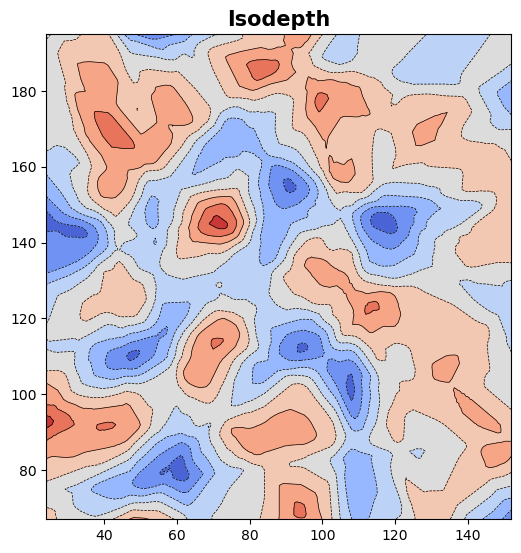

In [7]:
# Reload the input data
crop = pd.read_csv(save_dir+'/livm160_1_crop_1.csv',header=None).to_numpy()
S,A=crop[:,:2],crop[:,3:]

# MODEL TRAINED ABOVE
for seed in range(num_restarts):
    out_dir_seed=f"{save_dir}/rep{seed}/"
    os.makedirs(save_dir+'/isodepths_all_trials/', exist_ok=True)
    process_NN_output.plot_trials(out_dir_seed,save_dir+'/isodepths_all_trials/',S,seed)
# isodepth = np.loadtxt(=f"{save_dir}/rep{best_seed}/isodepth.txt")

# TO MATCH PAPER FIGURES
isodepth = np.loadtxt(f"paper_results/loss0.91032_trial3_isodepth.txt")
process_NN_output.plot_isodepth(isodepth, S, show_plot=True)

Then, we scale the best isodepth result to physical distance, make sure the isodepth follows the direction of the PN-CV axis such that the minimum depth corresponded to the portal node, and save the final result.

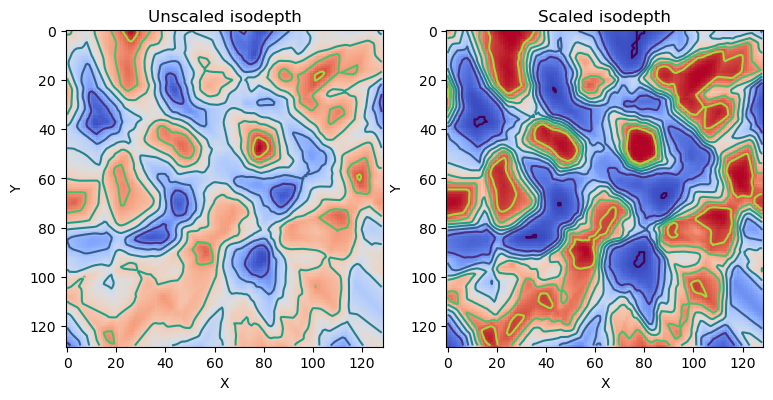

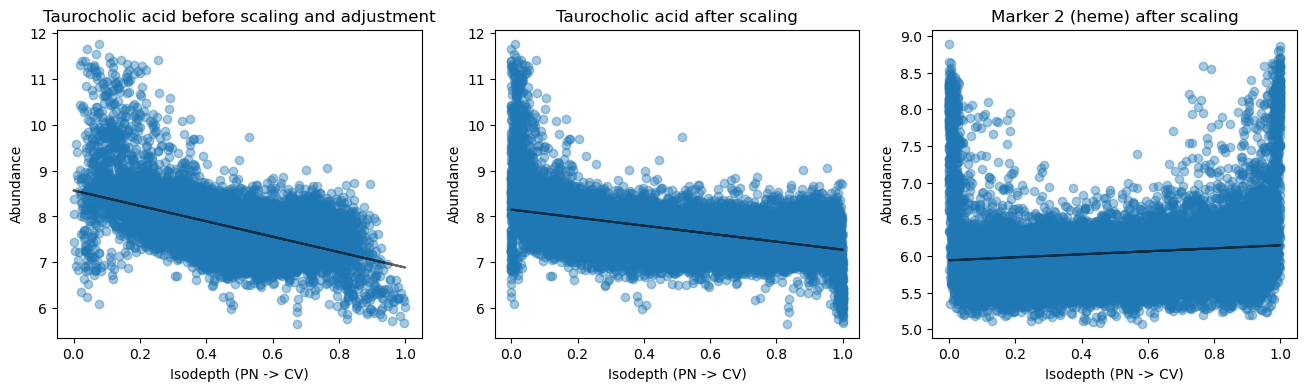

In [8]:
# Scale the isodepth, users may change the number of bins scale_n
scaled_isodepth = process_NN_output.adjust_isodepth(crop, isodepth, names, pv_id, heme_id,show_plot=True, scale_n = 350)
crop_w_isodepth = np.insert(crop, 3, scaled_isodepth, axis=1)
np.savetxt(save_dir+'/livm160_1_crop_1_finalisodepth.csv',crop_w_isodepth, delimiter=",")

OPTIONAL: To visualize the metabolic depths on all crops of this tissue slice, we uploaded the results used in paper, and we can plot them collectively.

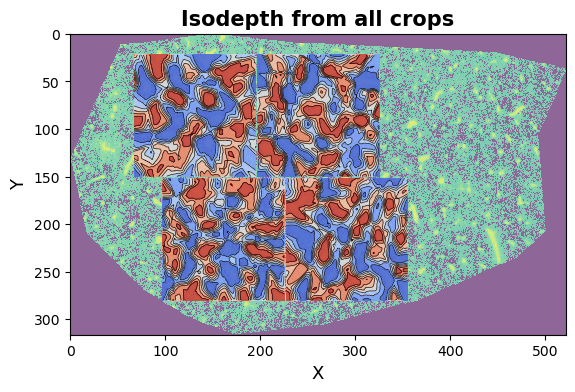

In [9]:
# Reload the whole slice
data_dir = '240526_livM160_1_ROI_02.csv'
X,Y,S,A = data_processing.process(data_dir)
whole_slice = np.hstack((S,A))
# Load the individual crop results
crops=[]
for i in [1,2,4,5]:
    crop = pd.read_csv(f'paper_results/livm160_1_crop_{i}_finalisodepth.csv',header=None).to_numpy()
    crops.append(crop)

process_NN_output.plot_all_crops(whole_slice, crops, heme_id, save_dir)